In [1]:
import pickle

data_to_load = {
    "X_train": None,
    "X_valid": None,
    "X_test": None,
    "y_train": None,
    "y_valid": None,
    "y_test": None,
    "y_mean": None, 
    "y_std": None,
    "df_test": None
}
for k in data_to_load.keys():
    with open(k + ".pkl", 'rb') as file:
        data_to_load[k] = pickle.load(file)
X_train, X_valid, X_test = data_to_load["X_train"], data_to_load["X_valid"], data_to_load["X_test"]
y_train, y_valid, y_test = data_to_load["y_train"], data_to_load["y_valid"], data_to_load["y_test"]
y_mean, y_std = data_to_load["y_mean"], data_to_load["y_std"]
df_test = data_to_load["df_test"]

In [2]:
import scutquant.scutquant as q
import pandas as pd

model = q.hybrid()
model.fit(X_train, y_train, X_valid, y_valid)

pred = model.predict(X_test)

pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += y_mean
pred["predict"] *= y_std
pred.describe()

[0]	validation_0-rmse:1.06489
[1]	validation_0-rmse:1.05556
[2]	validation_0-rmse:1.04693
[3]	validation_0-rmse:1.03897
[4]	validation_0-rmse:1.03158
[5]	validation_0-rmse:1.02476
[6]	validation_0-rmse:1.01844
[7]	validation_0-rmse:1.01265
[8]	validation_0-rmse:1.00727
[9]	validation_0-rmse:1.00230
[10]	validation_0-rmse:0.99774
[11]	validation_0-rmse:0.99355
[12]	validation_0-rmse:0.98967
[13]	validation_0-rmse:0.98611
[14]	validation_0-rmse:0.98281
[15]	validation_0-rmse:0.97980
[16]	validation_0-rmse:0.97700
[17]	validation_0-rmse:0.97443
[18]	validation_0-rmse:0.97206
[19]	validation_0-rmse:0.96989
[20]	validation_0-rmse:0.96788
[21]	validation_0-rmse:0.96604
[22]	validation_0-rmse:0.96434
[23]	validation_0-rmse:0.96278
[24]	validation_0-rmse:0.96135
[25]	validation_0-rmse:0.96003
[26]	validation_0-rmse:0.95882
[27]	validation_0-rmse:0.95772
[28]	validation_0-rmse:0.95670
[29]	validation_0-rmse:0.95576
[30]	validation_0-rmse:0.95490
[31]	validation_0-rmse:0.95411
[32]	validation_0-

,predict
count,280721.000000
mean,-0.000154
std,0.001381
min,-0.056890
25%,-0.000783
50%,-0.000079
75%,0.000584
max,0.029578


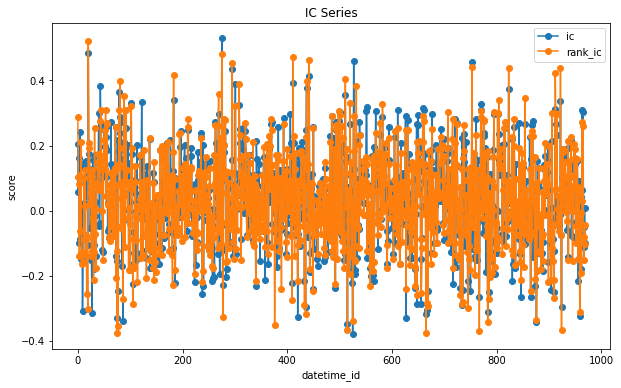

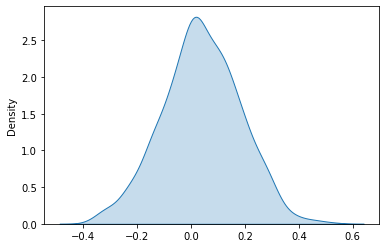

ic= 0.0374402474168715 icir= 0.2580987660449074 rank_ic= 0.031637214697116264 rank_icir= 0.2142509929387004


0.03350961603908639

In [3]:
ic, icir, rank_ic, rank_icir = q.ic_ana(pred["predict"], y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred["predict"].values, y_test)
r

In [4]:
from scutquant import executor, report

# 将预测值处理成回测需要的格式
pred = executor.prepare(pred, df_test, price='mean_price', volume='vol')
pred

predict       price     volume
time       code                                      
2019-01-02 000001.SZ  0.000133    9.252048  539386.32
           000002.SZ -0.001460   24.120738  247010.28
           000063.SZ  0.000362   19.088275  649682.72
           000069.SZ -0.000405    5.999183  403924.79
           000100.SZ  0.000686    2.515065  890514.27
...                        ...         ...        ...
2022-12-27 688363.SH -0.000956  136.312691   67620.51
           688396.SH  0.000608   53.127821   22894.05
           688561.SH -0.001903   65.791178   17585.16
           688599.SH -0.000226   62.192181  170829.80
           688981.SH -0.000328   41.078327   61293.26

[280267 rows x 3 columns]

Accuracy of Prediction: 0.5285459936417773


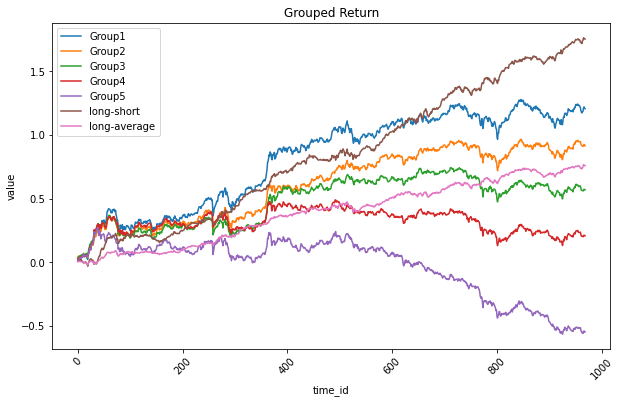

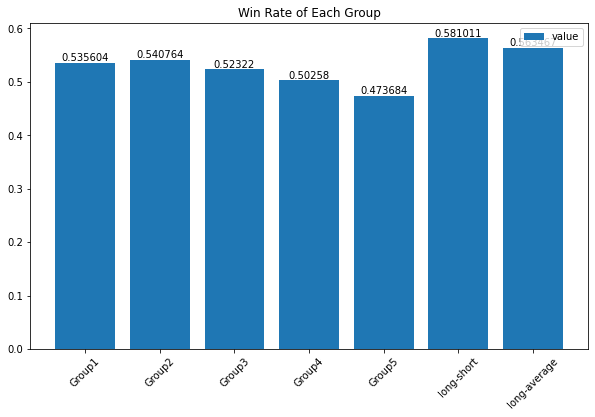

In [5]:
report.group_return_ana(pred, y_test)

In [6]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "TopKStrategy",
        "kwargs": {
            "sigma": 1,
            "auto_offset": False,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "short_volume": 5000,
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.5  # 手数随可用资金而改变，最大不会超过股票当天成交量的x%(例如T+1时下单，下单手数不会超过T时成交量的x%)
        }
    },
    "account": None,  # 使用默认账户, 即初始资金为1亿, 无底仓
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0005,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)

Annualized Return: 0.1940169345696967
Annualized Volatility: 0.6854791445163279
Annualized Return(Benchmark): 0.07899686073853784
Annualized Volatility(Benchmark): 0.3390023870788162 

Cumulative Rate of Return: 0.9775326194812777
Cumulative Rate of Return(Benchmark): 0.33958556303554865
Cumulative Excess Rate of Return: 0.637947056445729 

Max Drawdown: -0.36789364374663447
Max Drawdown(Benchmark): -0.5462600364770351 

Sharpe Ratio: 2.0266236254657417
Sortino Ratio: 2.2411252122277014
Information Ratio: 0.840947707999432 

Beta: 1.762210990258477
Alpha: -0.02201028037896169
Epsilon: 0.17142817002427035
Profitable Days(%): 0.9401444788441693


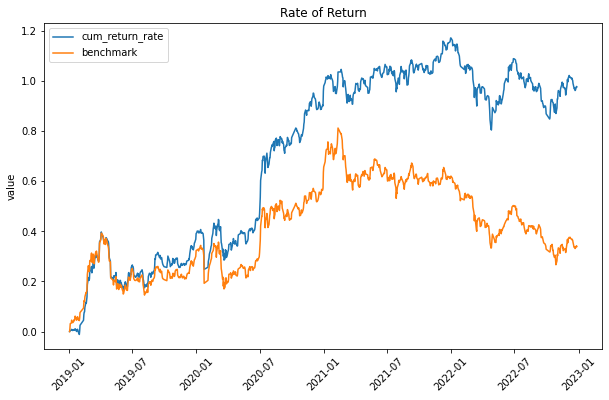

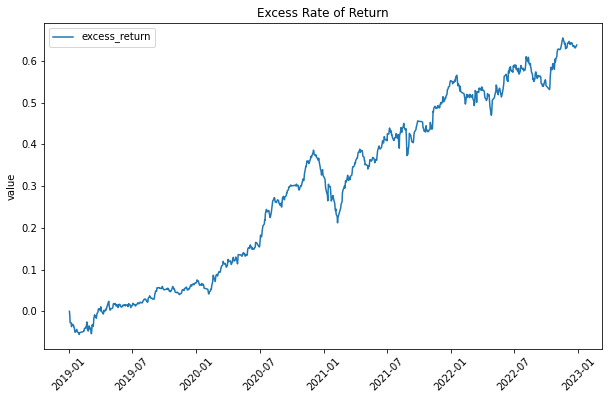

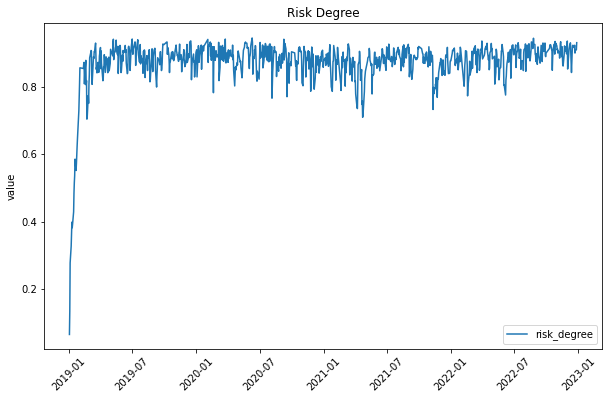

In [7]:
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节